# Noise

PyWake contains a simple noise-progagation model, `ISONoise`, which models the sound-pressure level from a number of sound sources (wind turbines) at a number of receivers taking into account:

- Spherical geometrical spreading (DSF/ISO/DIS 9613-2)
- Ground reflection/absorption (DSF/ISO/DIS 9613-2)
- Atmospheric absorption (DS/ISO 9613-1:1993)


The model is based on the iso standards:

```
DSF/ISO/DIS 9613-2
Acoustics – Attenuation of sound during propagation – Part 2:
Engineering method for the prediction of sound pressure levels outdoors
```

and

```
DS/ISO 9613-1:1993
Akustik. Måling og beskrivelse af ekstern støj. Lydudbredelsesdæmpning udendørs. Del 1:
Metode til beregning af luftabsorption
```

The implementation and interface is preliminary and may be subject to changes

In [0]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from py_wake.noise_models.iso import ISONoiseModel

from py_wake.deficit_models.gaussian import ZongGaussian
from py_wake.flow_map import XYGrid
from py_wake.turbulence_models.crespo import CrespoHernandez
from py_wake.site._site import UniformSite
from py_wake.examples.data.swt_dd_142_4100_noise.swt_dd_142_4100 import SWT_DD_142_4100
from py_wake.utils.layouts import rectangle
from py_wake.utils.plotting import setup_plot

## Sound source

To model the emitted sound from the wind turbine sources, the `WindTurbine` object must contain a `sound_power_level`-function.

An example wind turbine, `SWT_DD_142_4100`, is implemented in `py_wake.examples.data.swt_dd_142_4100_noise.swt_dd_142_4100` based on power, ct and noise data from the wind turbine catalogue in [WindPro](https://www.emd-international.com/software/) (demo version).

This wind turbine are able to operate at 7 different modes with reduced power and noise.

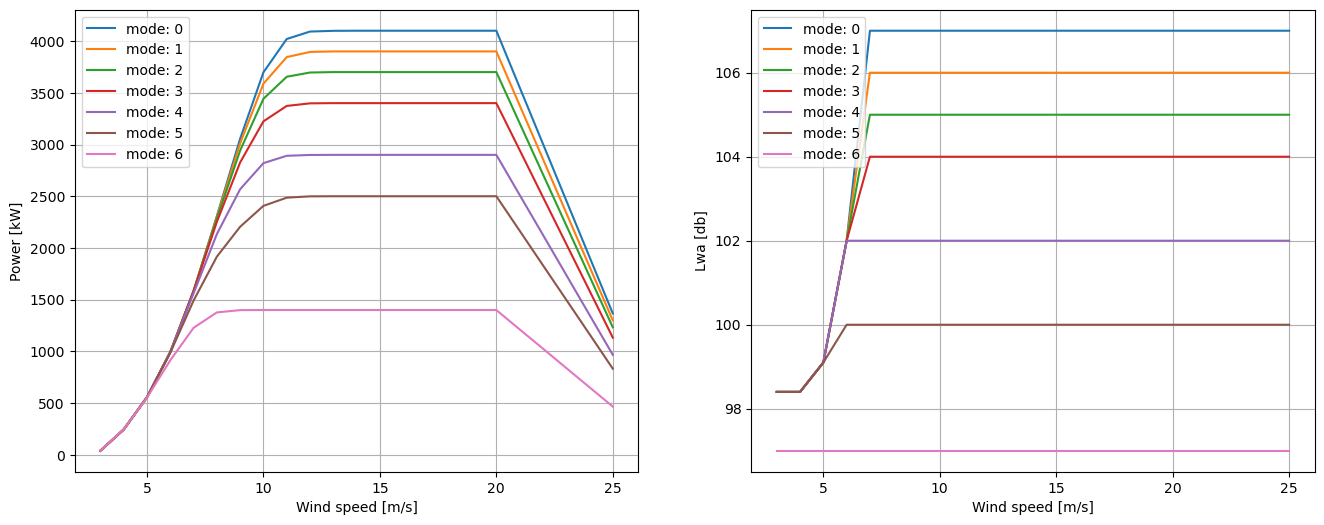

In [2]:
wt = SWT_DD_142_4100()

ax1,ax2 = plt.subplots(1,2,figsize=(16,6))[1]
ws = np.arange(3, 26)
for m in range(7):
    ax1.plot(ws, wt.power(ws, mode=m) / 1000, label=f'mode: {m}')
    ax2.plot(ws, wt.ds.LwaRef.sel(mode=m, ws=ws), label=f'mode: {m}')

setup_plot(ax=ax1, xlabel='Wind speed [m/s]', ylabel='Power [kW]')
setup_plot(ax=ax2, xlabel='Wind speed [m/s]', ylabel='Lwa [db]')

Furthermore, the sound-power level is available as a function of mode, wind speed and frequency  

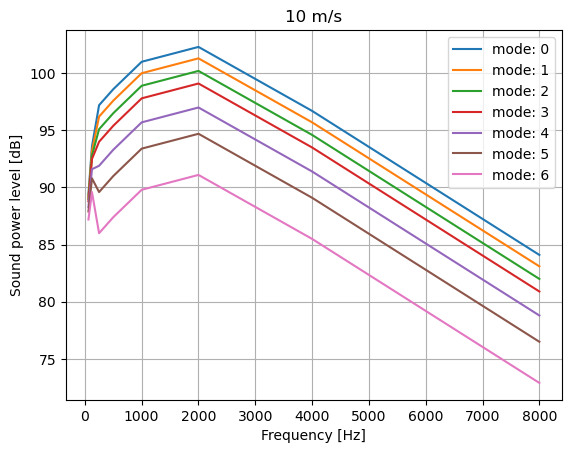

In [3]:
for m in range(7):
    freq, sound_power = wt.sound_power_level(ws=10, mode=m)
    plt.plot(freq, sound_power[0], label=f'mode: {m}')
setup_plot(xlabel='Frequency [Hz]', ylabel='Sound power level [dB]', title="10 m/s")

## Noise at receivers
To model the noise at specific receiver positions, we first need to setup a `WindFarmModel´ and run a simulation

In [4]:
wt = SWT_DD_142_4100()
wfm = ZongGaussian(UniformSite(), wt, turbulenceModel=CrespoHernandez())
x, y = rectangle(5, 5, 5 * wt.diameter())
sim_res = wfm(x, y, wd=270, ws=8, mode=[0,0,6,0,0])

In this case the wind farm consist of 5 wind turbines in a row aligned with the wind. 
Wind turbines, 0,1 and 3,4 operate in mode 0 while wind turbin 2 is running in the most derated and silent mode. 

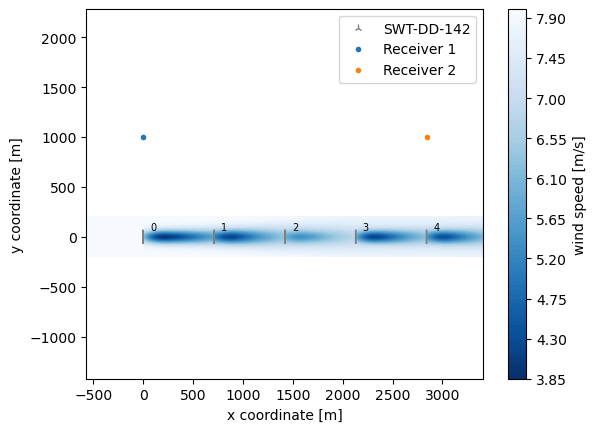

In [5]:
sim_res.flow_map().plot_wake_map()
plt.plot([x[0]], [1000], '.', label='Receiver 1')
plt.plot([x[-1]], [1000], '.', label='Receiver 2')
setup_plot(grid=False, xlabel='x coordinate [m]', ylabel='y coordinate [m]')

We can no model the sound pressure level at the two recievers. In this case the upstream wind turbines operates at higher wind speed than the down wind turbines, and therefore a higher sound pressure level will be reveived at receiver 1. 

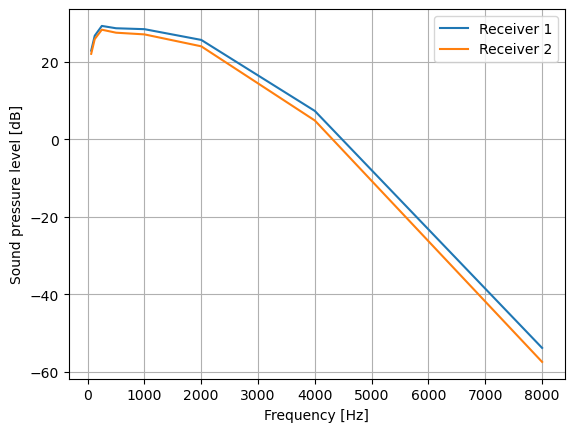

In [6]:
nm = sim_res.noise_model()
total_sp_jlk, spl_jlkf = nm(rec_x=[x[0], x[-1]], rec_y=[1000, 1000], rec_h=2, Temp=20, RHum=80, ground_type=0.0)
plt.plot(nm.freqs, spl_jlkf[0, 0, 0], label='Receiver 1')
plt.plot(nm.freqs, spl_jlkf[1, 0, 0], label='Receiver 2')
setup_plot(xlabel='Frequency [Hz]', ylabel='Sound pressure level [dB]')

Finally, a sound map can be generated

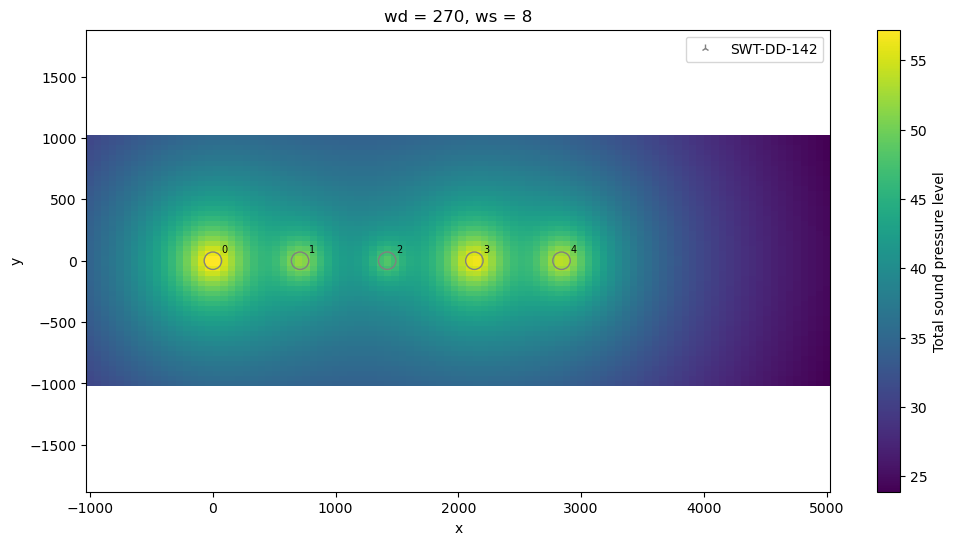

In [7]:
plt.figure(figsize=(12,6))
nmap = sim_res.noise_map(grid=XYGrid(x=np.linspace(-1000, 5000, 100), y=np.linspace(-1000, 1000, 50), h=2))
nmap['Total sound pressure level'].squeeze().plot()
wt.plot(x, y)